In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [3]:
SEASON = '23'
set_seed(int(SEASON))

## Download HKJC odds

In [61]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [62]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [63]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [64]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [65]:
matches_json = json.loads(response.text)['matches']

In [66]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [67]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20240106SATFB0132', '2024-Jan-06', '01:00:00', 'French FA Cup [FFA]', 'Pau FC', 'Nantes', 'true', '9.5', '2.00', '1.72', 'false', '10.5', '2.60', '1.43', 'false', '12.5', '4.40', '1.15']
['20240106SATFB0129', '2024-Jan-06', '02:45:00', 'Portuguese Premier [PFL]', 'Sporting', 'Estoril', 'true', '10.5', '2.20', '1.59', 'false', '11.5', '2.75', '1.38', 'false', '13.5', '4.75', '1.13']
['20240106SATFB0126', '2024-Jan-06', '03:15:00', 'FA Cup [EFA]', 'Brentford', 'Wolves', 'true', '10.5', '2.17', '1.61', 'false', '11.5', '2.70', '1.39', 'false', '13.5', '4.75', '1.13']
['20240106SATFB0127', '2024-Jan-06', '03:30:00', 'FA Cup [EFA]', 'Fulham', 'Rotherham', 'true', '11.5', '2.30', '1.54', 'false', '12.5', '2.88', '1.35', 'false', '14.5', '4.95', '1.12']
['20240106SATFB0134', '2024-Jan-06', '03:45:00', 'Italian Division 1 [ISA]', 'Bologna', 'Genoa', 'true', '8.5', '1.83', '1.87', 'false', '11.5', '4.05', '1.18', 'false', '9.5', '2.38', '1.51']
['20240106SATFB0131', '2024-Jan-06', '03:45:00',

In [68]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [69]:
odds = [o for o in odds if len(o) == 18]

In [70]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [71]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [72]:
odds

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE_0,CHL_LINE_0,CHL_H_0,CHL_L_0,MAINLINE_1,CHL_LINE_1,CHL_H_1,CHL_L_1,MAINLINE_2,CHL_LINE_2,CHL_H_2,CHL_L_2
0,20240106SATFB0132,2024-Jan-06,01:00:00,French FA Cup [FFA],Pau FC,Nantes,true,9.5,2.00,1.72,false,10.5,2.60,1.43,false,12.5,4.40,1.15
1,20240106SATFB0129,2024-Jan-06,02:45:00,Portuguese Premier [PFL],Sporting,Estoril,true,10.5,2.20,1.59,false,11.5,2.75,1.38,false,13.5,4.75,1.13
2,20240106SATFB0126,2024-Jan-06,03:15:00,FA Cup [EFA],Brentford,Wolves,true,10.5,2.17,1.61,false,11.5,2.70,1.39,false,13.5,4.75,1.13
3,20240106SATFB0127,2024-Jan-06,03:30:00,FA Cup [EFA],Fulham,Rotherham,true,11.5,2.30,1.54,false,12.5,2.88,1.35,false,14.5,4.95,1.12
4,20240106SATFB0134,2024-Jan-06,03:45:00,Italian Division 1 [ISA],Bologna,Genoa,true,8.5,1.83,1.87,false,11.5,4.05,1.18,false,9.5,2.38,1.51
5,20240106SATFB0131,2024-Jan-06,03:45:00,French FA Cup [FFA],Metz,Clermont,true,8.5,1.86,1.84,false,11.5,4.30,1.16,false,9.5,2.43,1.49
6,20240106SATFB0128,2024-Jan-06,04:00:00,FA Cup [EFA],Tottenham,Burnley,true,11.5,2.25,1.57,false,12.5,2.80,1.37,false,14.5,4.75,1.13
7,20240106SATFB0133,2024-Jan-06,04:45:00,Portuguese Premier [PFL],Boavista,Porto,true,10.5,2.04,1.69,false,11.5,2.58,1.44,false,14.5,5.60,1.09
8,20240106SATFB0178,2024-Jan-06,14:30:00,Australian Division 1 [AD1],Western Sydney Wanderers,Central Coast Mariners,true,11.5,1.94,1.76,false,12.5,2.35,1.52,false,14.5,3.80,1.21
9,20240106SATFB0177,2024-Jan-06,16:45:00,Australian Division 1 [AD1],Brisbane Roar,Sydney FC,true,11.5,2.02,1.70,false,12.5,2.55,1.45,false,14.5,4.05,1.18


In [73]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [74]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [75]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [76]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2', 'UCL', 'UEC', 'UEF', 'EFA', 'SFC']
map_league = map_league[map_league.Div.isin(div)].reset_index(drop=True)

In [77]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [78]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [79]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [80]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [81]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [82]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [83]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [84]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [85]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [86]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [87]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [88]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [89]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [90]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [91]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,SATFB0126,SATFB0127,SATFB0128,SATFB0168,SATFB0160
Date,2024-01-06 00:00:00,2024-01-06 00:00:00,2024-01-06 00:00:00,2024-01-06 00:00:00,2024-01-06 00:00:00
Time,03:15:00,03:30:00,04:00:00,20:30:00,20:30:00
LeagueJC,FA Cup [EFA],FA Cup [EFA],FA Cup [EFA],FA Cup [EFA],FA Cup [EFA]
HomeTeamJC,Brentford,Fulham,Tottenham,Millwall,AFC Wimbledon
AwayTeamJC,Wolves,Rotherham,Burnley,Leicester,Ipswich
MAINLINE_0,true,true,true,true,true
CHL_LINE_0,10.5,11.5,11.5,10.5,10.5
CHL_H_0,2.17,2.3,2.25,2.25,2.05
CHL_L_0,1.61,1.54,1.57,1.57,1.68


## Load model

In [92]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [93]:
to = load_pandas('models/to.pkl')

In [94]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [95]:
odds = odds.dropna(how='any')

In [96]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [97]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
0,#na#,Brentford,Wolves,15.8,4.8,12.0,4.8,12.6,11.2,12.0,12.6
1,#na#,Fulham,Rotherham,15.4,6.4,8.2,3.4,12.2,6.2,12.6,16.8
2,#na#,Tottenham,Burnley,17.0,4.8,7.8,4.6,18.0,9.6,13.6,16.6
3,#na#,Millwall,Leicester,11.8,3.4,10.4,3.6,9.8,13.4,13.0,10.0
4,#na#,AFC Wimbledon,Ipswich,11.8,4.6,8.0,4.0,18.0,11.2,12.4,9.4
5,#na#,Sunderland,Newcastle,19.0,7.4,11.6,5.4,15.4,16.6,10.2,16.2
6,#na#,Stoke,Brighton,13.4,5.0,12.0,3.4,13.8,17.2,10.6,14.0
7,#na#,QPR,Bournemouth,16.0,7.0,13.4,5.4,13.2,14.0,10.6,13.2
8,#na#,Gillingham,Sheffield United,11.2,4.8,5.6,2.4,13.2,9.4,8.8,12.8
9,#na#,Southampton,#na#,15.0,6.8,10.8,5.0,16.8,14.0,7.8,13.4


In [98]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [99]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [100]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [101]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [102]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [103]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [104]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [105]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,SATFB0126,2024-01-06,03:15:00,FA Cup [EFA],Brentford,Wolves,True,10.5,2.17,1.61,0.077411,0.083757,4.281274,4.713950,-46.703995,-0.124900
1,SATFB0127,2024-01-06,03:30:00,FA Cup [EFA],Fulham,Rotherham,True,11.5,2.30,1.54,0.039151,0.101353,7.506943,3.948910,-55.786774,-0.113175
2,SATFB0128,2024-01-06,04:00:00,FA Cup [EFA],Tottenham,Burnley,True,11.5,2.25,1.57,0.066784,0.134827,6.648095,3.135789,-47.871220,-0.168605
3,SATFB0168,2024-01-06,20:30:00,FA Cup [EFA],Millwall,Leicester,True,10.5,2.25,1.57,0.073342,0.084105,4.775533,4.495726,-47.548271,-0.124872
4,SATFB0160,2024-01-06,20:30:00,FA Cup [EFA],AFC Wimbledon,Ipswich,True,10.5,2.05,1.68,0.076207,0.081845,4.576502,5.004524,-48.792580,-0.132353


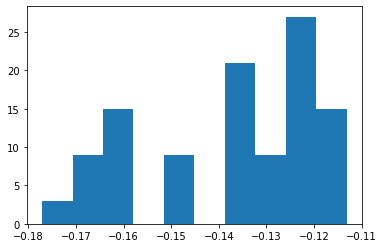

In [106]:
odds['corr'].hist(grid=False);

In [107]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

In [108]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [109]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [110]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [111]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [112]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [113]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.35, '$$$', np.where(
            odds['kelly']>0.25, '$$', np.where(
                odds['kelly']>0.15, '$', None))), 
    None
)

In [114]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [115]:
odds[odds.bet.notna() & odds.selected.notna()].reset_index(drop=True)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,MONFB0139,2024-01-08,00:30:00,FA Cup [EFA],Arsenal,Liverpool,True,10.5,1.84,1.86,0.284402,0.715598,0.384897,Low,$$$
1,SUNFB0172,2024-01-07,00:00:00,Spanish Cup [SFC],Espanyol,Getafe,True,9.5,2.13,1.63,0.299168,0.700832,0.225963,Low,$
2,SUNFB0136,2024-01-07,01:00:00,Italian Division 1 [ISA],Lecce,Cagliari,True,9.5,1.93,1.77,0.625980,0.374020,0.223808,High,$
3,SATFB0171,2024-01-06,23:00:00,FA Cup [EFA],Blackburn,Cambridge Utd,True,10.5,1.94,1.76,0.338487,0.661513,0.216135,Low,$
4,SATFB0126,2024-01-06,03:15:00,FA Cup [EFA],Brentford,Wolves,True,10.5,2.17,1.61,0.303225,0.696775,0.199684,Low,$
5,SATFB0128,2024-01-06,04:00:00,FA Cup [EFA],Tottenham,Burnley,True,11.5,2.25,1.57,0.291214,0.708786,0.197885,Low,$
6,SATFB0189,2024-01-06,22:00:00,Italian Division 1 [ISA],Frosinone,Monza,True,10.5,2.20,1.59,0.306883,0.693117,0.172975,Low,$
7,SUNFB0190,2024-01-07,22:00:00,Italian Division 1 [ISA],Udinese,Lazio,True,9.5,1.93,1.77,0.596629,0.403371,0.162897,High,$
8,SUNFB0174,2024-01-07,01:30:00,FA Cup [EFA],Chelsea,Preston,True,10.5,1.85,1.85,0.385848,0.614152,0.160214,Low,$
9,SUNFB0180,2024-01-07,22:00:00,FA Cup [EFA],Peterborough,Leeds,True,11.5,2.05,1.68,0.343617,0.656383,0.151063,Low,$


In [116]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,MONFB0139,2024-01-08,00:30:00,FA Cup [EFA],Arsenal,Liverpool,False,14.5,4.95,1.12,0.051442,0.948558,0.519872,Low,None
1,MONFB0139,2024-01-08,00:30:00,FA Cup [EFA],Arsenal,Liverpool,False,11.5,2.30,1.54,0.198319,0.801681,0.434425,Low,None
2,SATFB0171,2024-01-06,23:00:00,FA Cup [EFA],Blackburn,Cambridge Utd,False,14.5,4.75,1.13,0.069396,0.930604,0.396786,Low,None
3,MONFB0139,2024-01-08,00:30:00,FA Cup [EFA],Arsenal,Liverpool,True,10.5,1.84,1.86,0.284402,0.715598,0.384897,Low,$$$
4,SUNFB0172,2024-01-07,00:00:00,Spanish Cup [SFC],Espanyol,Getafe,False,10.5,2.68,1.40,0.205893,0.794107,0.279376,Low,None
5,SATFB0171,2024-01-06,23:00:00,FA Cup [EFA],Blackburn,Cambridge Utd,False,11.5,2.40,1.50,0.243326,0.756674,0.270021,Low,None
6,SUNFB0172,2024-01-07,00:00:00,Spanish Cup [SFC],Espanyol,Getafe,False,12.5,4.75,1.13,0.084196,0.915804,0.268141,Low,None
7,SATFB0126,2024-01-06,03:15:00,FA Cup [EFA],Brentford,Wolves,False,11.5,2.70,1.39,0.213483,0.786517,0.239125,Low,None
8,SATFB0128,2024-01-06,04:00:00,FA Cup [EFA],Tottenham,Burnley,False,12.5,2.80,1.37,0.207743,0.792257,0.230789,Low,None
9,SUNFB0172,2024-01-07,00:00:00,Spanish Cup [SFC],Espanyol,Getafe,True,9.5,2.13,1.63,0.299168,0.700832,0.225963,Low,$


In [117]:
odds[odds.MAINLINE].to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)